##### the goal is here to see what exactly is happening in the wfd-depth outputs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
import pandas as pd
%matplotlib inline

In [2]:
import time
import copy
import numpy as np
import healpy as hp
import os
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

import lsst.sims.maf.maps as maps

In [3]:
%matplotlib inline

In [4]:
fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize'%axis] = fontsize-2
    rcparams['%stick.direction'%axis] = 'in'
    rcparams['%stick.major.size'%axis] = 5.5
    rcparams['%stick.minor.size'%axis] =  3.5
    rcparams['%stick.major.width'%axis] = 2
    rcparams['%stick.minor.width'%axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True
for key in rcparams: mpl.rcParams[key] = rcparams[key]

In [5]:
dbdir = '/global/cscratch1/sd/awan/dbs_post_wp_v3'

print( ['%s' % f.split('.db')[0] for f in os.listdir(dbdir) if f.__contains__('wfd_depth') and f.__contains__('noddf') ] )
print( ['%s' % f.split('.db')[0] for f in os.listdir(dbdir) if f.__contains__('wfd_depth') and not f.__contains__('noddf') ] )

['wfd_depth_scale0.95_noddf_v1.4_10yrs', 'wfd_depth_scale0.80_noddf_v1.4_10yrs', 'wfd_depth_scale0.75_noddf_v1.4_10yrs', 'wfd_depth_scale0.70_noddf_v1.4_10yrs', 'wfd_depth_scale0.99_noddf_v1.4_10yrs', 'wfd_depth_scale0.90_noddf_v1.4_10yrs', 'wfd_depth_scale0.65_noddf_v1.4_10yrs', 'wfd_depth_scale0.85_noddf_v1.4_10yrs']
['wfd_depth_scale0.99_v1.4_10yrs', 'wfd_depth_scale0.65_v1.4_10yrs', 'wfd_depth_scale0.95_v1.4_10yrs', 'wfd_depth_scale0.75_v1.4_10yrs', 'wfd_depth_scale0.90_v1.4_10yrs', 'wfd_depth_scale0.80_v1.4_10yrs', 'wfd_depth_scale0.70_v1.4_10yrs', 'wfd_depth_scale0.85_v1.4_10yrs']


In [6]:
baseline_key = 'baseline_v1.4_10yrs'

dbnames = ['wfd_depth_scale%.2f_noddf_v1.4_10yrs' % f for f in np.arange(0.65, 0.99, 0.05)]

dbnames += ['wfd_depth_scale%.2f_noddf_v1.4_10yrs' % 0.99]

dbnames += [ baseline_key ]
dbnames

['wfd_depth_scale0.65_noddf_v1.4_10yrs',
 'wfd_depth_scale0.70_noddf_v1.4_10yrs',
 'wfd_depth_scale0.75_noddf_v1.4_10yrs',
 'wfd_depth_scale0.80_noddf_v1.4_10yrs',
 'wfd_depth_scale0.85_noddf_v1.4_10yrs',
 'wfd_depth_scale0.90_noddf_v1.4_10yrs',
 'wfd_depth_scale0.95_noddf_v1.4_10yrs',
 'wfd_depth_scale0.99_noddf_v1.4_10yrs',
 'baseline_v1.4_10yrs']

In [7]:
dbnames_base = dbnames.copy()

dbnames += ['wfd_depth_scale%.2f_v1.4_10yrs' % f for f in np.arange(0.65, 0.99, 0.05)]
dbnames += ['wfd_depth_scale%.2f_v1.4_10yrs' % 0.99]

In [8]:
dbnames_base, dbnames

(['wfd_depth_scale0.65_noddf_v1.4_10yrs',
  'wfd_depth_scale0.70_noddf_v1.4_10yrs',
  'wfd_depth_scale0.75_noddf_v1.4_10yrs',
  'wfd_depth_scale0.80_noddf_v1.4_10yrs',
  'wfd_depth_scale0.85_noddf_v1.4_10yrs',
  'wfd_depth_scale0.90_noddf_v1.4_10yrs',
  'wfd_depth_scale0.95_noddf_v1.4_10yrs',
  'wfd_depth_scale0.99_noddf_v1.4_10yrs',
  'baseline_v1.4_10yrs'],
 ['wfd_depth_scale0.65_noddf_v1.4_10yrs',
  'wfd_depth_scale0.70_noddf_v1.4_10yrs',
  'wfd_depth_scale0.75_noddf_v1.4_10yrs',
  'wfd_depth_scale0.80_noddf_v1.4_10yrs',
  'wfd_depth_scale0.85_noddf_v1.4_10yrs',
  'wfd_depth_scale0.90_noddf_v1.4_10yrs',
  'wfd_depth_scale0.95_noddf_v1.4_10yrs',
  'wfd_depth_scale0.99_noddf_v1.4_10yrs',
  'baseline_v1.4_10yrs',
  'wfd_depth_scale0.65_v1.4_10yrs',
  'wfd_depth_scale0.70_v1.4_10yrs',
  'wfd_depth_scale0.75_v1.4_10yrs',
  'wfd_depth_scale0.80_v1.4_10yrs',
  'wfd_depth_scale0.85_v1.4_10yrs',
  'wfd_depth_scale0.90_v1.4_10yrs',
  'wfd_depth_scale0.95_v1.4_10yrs',
  'wfd_depth_scale0.99_v1

In [9]:
depth_dir = '/global/cscratch1/sd/awan/lsst_output/post_wp_output_v1.4_-0.1cuts/bundle_data/'
ilim = 25.9

depth_bundles = {}

for dbname in dbnames:
    file = [f for f in os.listdir(depth_dir) if f.__contains__('depth_in_eg_%s' % dbname) and \
                f.__contains__('limi%s' % ilim)
               ]
    print(file)
    
    depth_bundles[dbname] = metricBundles.createEmptyMetricBundle()
    depth_bundles[dbname].read('%s/%s' % (depth_dir, file[0]))
        

['depth_in_eg_wfd_depth_scale0.65_noddf_v1.4_10yrs_i-band_limi25.9_nodither_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
['depth_in_eg_wfd_depth_scale0.70_noddf_v1.4_10yrs_i-band_limi25.9_nodither_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
['depth_in_eg_wfd_depth_scale0.75_noddf_v1.4_10yrs_i-band_limi25.9_nodither_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
['depth_in_eg_wfd_depth_scale0.80_noddf_v1.4_10yrs_i-band_limi25.9_nodither_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
['depth_in_eg_wfd_depth_scale0.85_noddf_v1.4_10yrs_i-band_limi25.9_nodither_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
['depth_in_eg_wfd_depth_scale0.90_noddf_v1.4_10yrs_i-band_limi25.9_nodither_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminute

In [10]:
area_ppixel = hp.nside2pixarea(nside=256, degrees=True)

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2020_05/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


<Figure size 720x432 with 0 Axes>

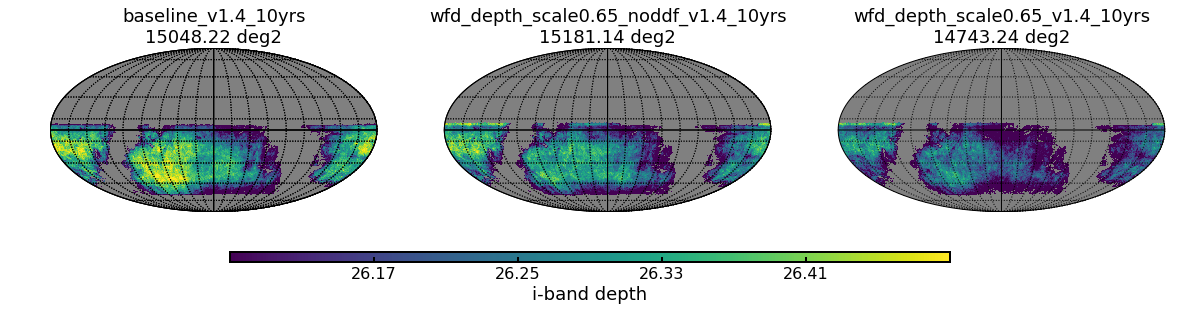

<Figure size 720x432 with 0 Axes>

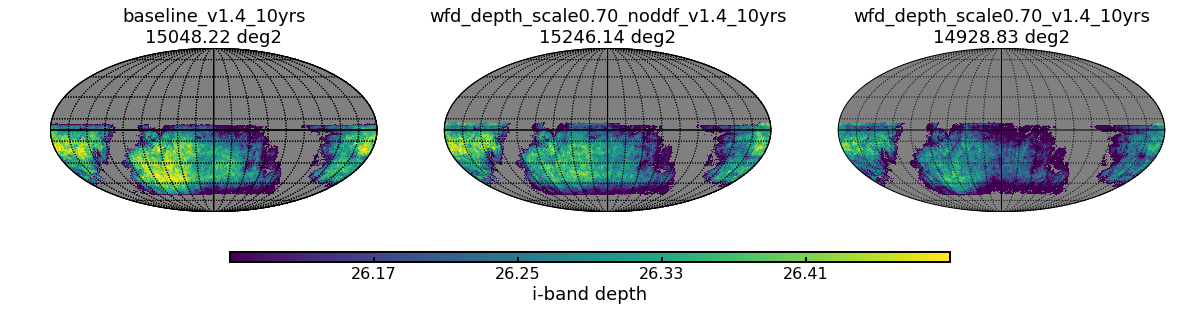

<Figure size 720x432 with 0 Axes>

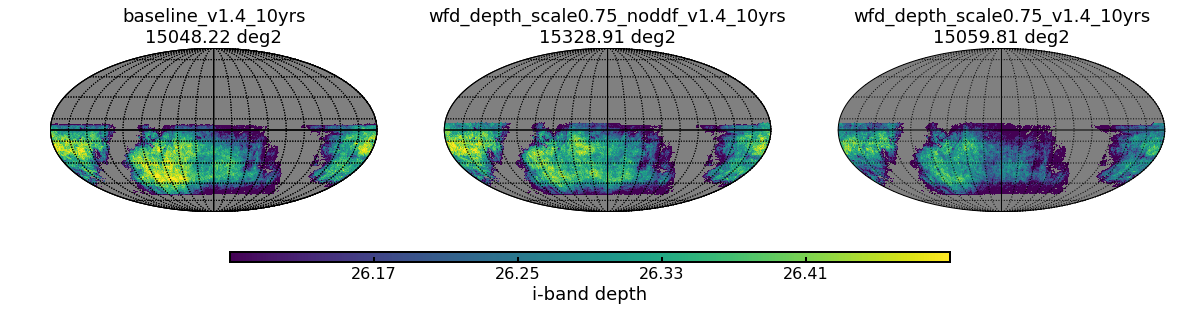

<Figure size 720x432 with 0 Axes>

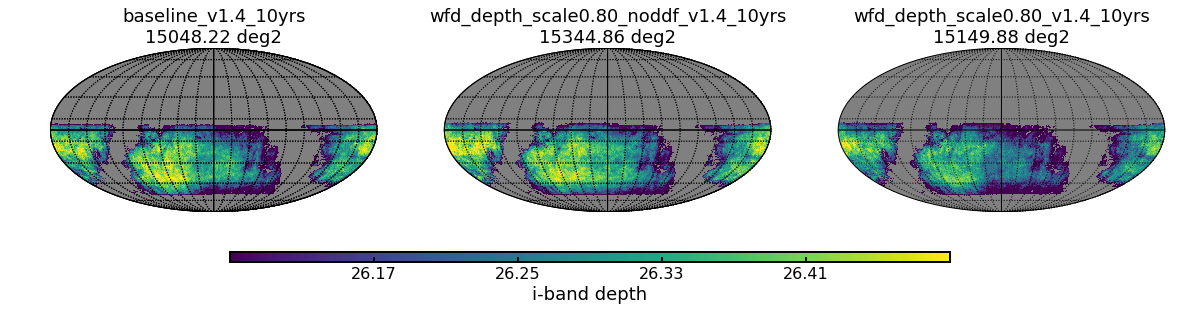

<Figure size 720x432 with 0 Axes>

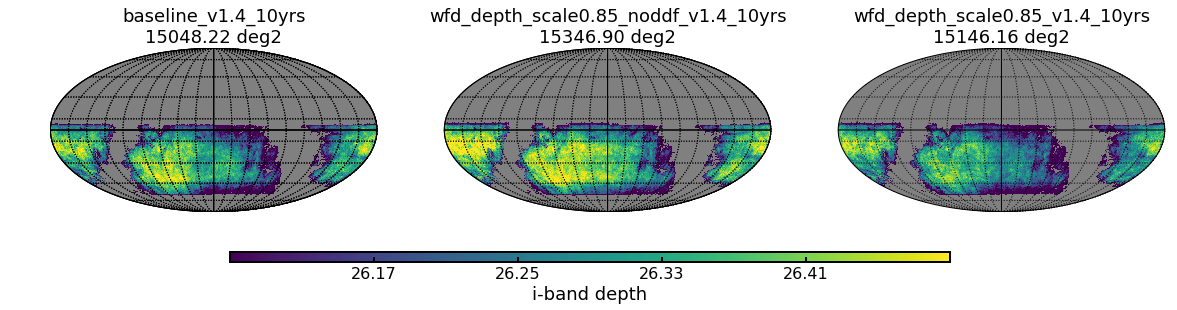

<Figure size 720x432 with 0 Axes>

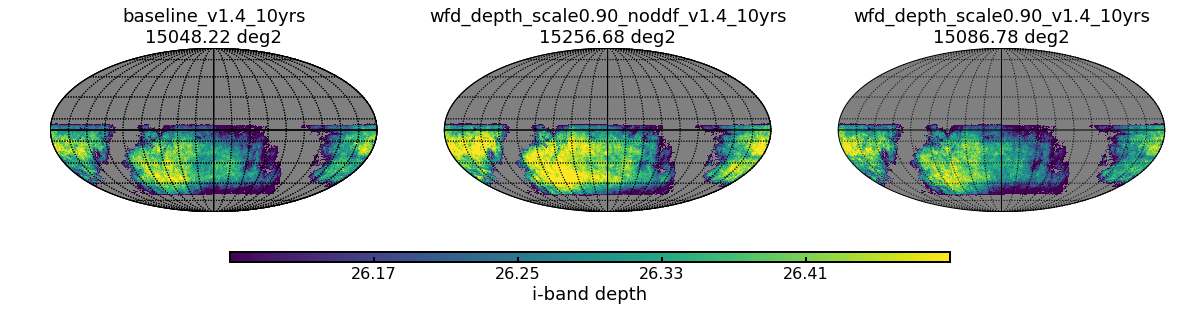

<Figure size 720x432 with 0 Axes>

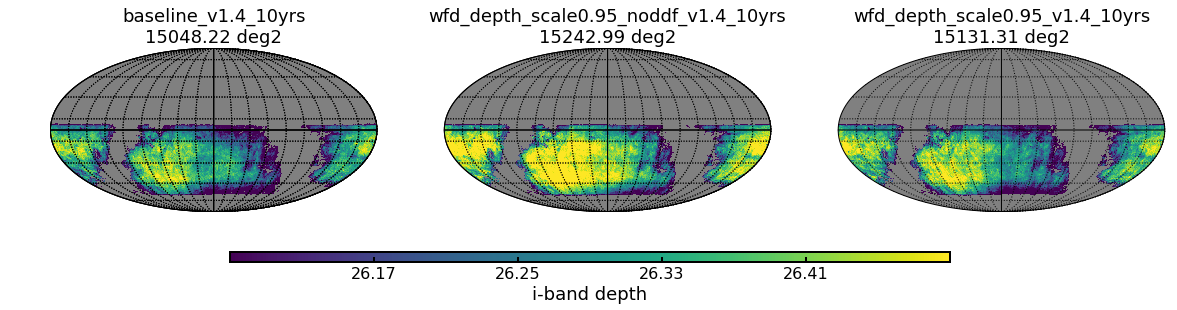

<Figure size 720x432 with 0 Axes>

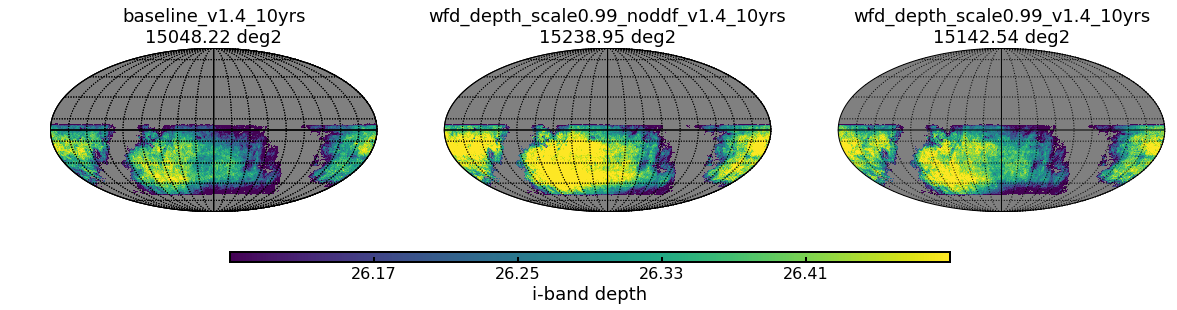

In [11]:
for dbname in [f for f in dbnames_base if not f.__contains__('baseline')]:
    
    plt.clf()
    fig, axes= plt.subplots(1,3)
    
    # color scale based on the baseline
    in_survey_pixels = np.where( depth_bundles[baseline_key].metricValues.mask == False )[0]
    # find the color range
    median = np.median(depth_bundles[baseline_key].metricValues.data[in_survey_pixels])
    stddev = np.std(depth_bundles[baseline_key].metricValues.data[in_survey_pixels])

    colormin = median - 1.5 * stddev
    colormax = median + 1.5 * stddev
    nticks = 5

    # baseline
    title = '%s\n%.2f deg2' % (baseline_key, len(in_survey_pixels) * area_ppixel)
    plt.axes(axes[0])
    hp.mollview(depth_bundles[baseline_key].metricValues, flip='astro', rot=(0,0,0),
                min=colormin, max=colormax, hold=True,
                cbar=False, title=title)
    hp.graticule(dpar=20, dmer=20, verbose=False)

    
    # now plot this d
    in_survey_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    title = '%s\n%.2f deg2' % (dbname, len(in_survey_pixels) * area_ppixel)
    
    plt.axes(axes[1])
    hp.mollview(depth_bundles[dbname].metricValues, flip='astro', rot=(0,0,0),
                min=colormin, max=colormax, hold=True,
                cbar=False, title=title)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    
    
    # plot the on wddf
    plt.axes(axes[2])
    dbname = dbname.replace('_noddf', '')
    in_survey_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    title = '%s\n%.2f deg2' % (dbname, len(in_survey_pixels) * area_ppixel)
    
    hp.mollview(depth_bundles[dbname].metricValues, flip='astro', rot=(0,0,0),
                min=colormin, max=colormax, hold=True,
                cbar=False, title=title)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    
    
    
    # set up the color bar
    increment = (colormax - colormin) / float(nticks)
    ticks = np.arange(colormin + increment, colormax, increment)

    ax = plt.gca()
    im = ax.get_images()[0]
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.25, 0.38, 0.5, 0.01]) # [left, bottom, width, height]
    cb = plt.colorbar(im, orientation='horizontal',
                      ticks=ticks, format='%.2f', cax=cbaxes
                     )
    cb.set_label( 'i-band depth' )
    fig.set_size_inches(20, 15)
    plt.show()


In [12]:
min_all, max_all = 1000, -1000
for dbname in dbnames:

    in_survey_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    min_all = min( [ min_all, min(depth_bundles[dbname].metricValues.data[in_survey_pixels]) ])
    
    max_all = max( [ max_all, max(depth_bundles[dbname].metricValues.data[in_survey_pixels]) ])
    
print(min_all, max_all)

25.900000649023248 26.685851111975968


In [13]:
from matplotlib import cm
colors = [cm.viridis(i) for i in np.arange(0, 255, int(255/(len(dbnames_base)-1)))]
colors.reverse()

<Figure size 720x432 with 0 Axes>

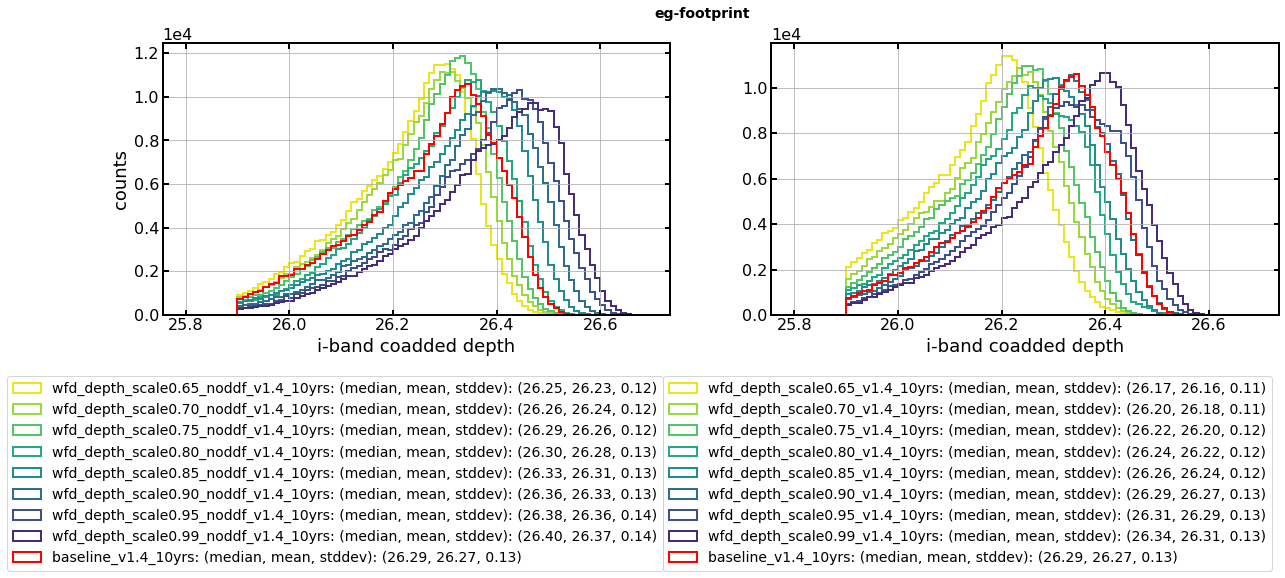

In [14]:
bins = np.arange(25.8, 26.7, 0.01)

plt.clf()
fig, axes = plt.subplots(1,2)

for i, dbname in enumerate( [f for f in dbnames_base if not f.__contains__('baseline')] ):

    in_survey_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    
    median = np.median(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    mean = np.mean(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    stddev = np.std(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    label = '%s: (median, mean, stddev): (%.2f, %.2f, %.2f)' % (dbname, median, mean, stddev)

    out = axes[0].hist( list(depth_bundles[dbname].metricValues.data[in_survey_pixels]), color=colors[i], label=label, histtype='step', lw=2, bins=bins)
    
    # no dff
    dbname = dbname.replace('_noddf', '')
    in_survey_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    
    median = np.median(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    mean = np.mean(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    stddev = np.std(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    label = '%s: (median, mean, stddev): (%.2f, %.2f, %.2f)' % (dbname, median, mean, stddev)
    
    axes[1].hist( list(depth_bundles[dbname].metricValues.data[in_survey_pixels]), color=colors[i], label=label, histtype='step', lw=2, bins=bins)

for ax in axes:
    dbname = baseline_key
    in_survey_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    
    median = np.median(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    mean = np.mean(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    stddev = np.std(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    label = '%s: (median, mean, stddev): (%.2f, %.2f, %.2f)' % (dbname, median, mean, stddev)
    
    ax.hist( list(depth_bundles[dbname].metricValues.data[in_survey_pixels]), color='r', label=label, histtype='step', lw=2, bins=bins)
    
    ax.set_xlabel('i-band coadded depth')
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
axes[0].set_ylabel('counts')
axes[0].legend(bbox_to_anchor = (1, -0.2))
axes[1].legend(bbox_to_anchor = (1, -0.2))
plt.suptitle('eg-footprint', fontweight="bold", fontsize=14)
fig.set_size_inches(20, 5)
plt.show()

##### i do not understand how one could have 65% of the wfd visits and achieve a depth distribution so similar to the baseline